A notebook with a simple example of two datapoints of two hypothetical fish to explore relative angles between the two. For the implementation of algorithms that include relative positions between the fish and their heading trajectories.

In [1]:
from math import atan2, degrees
import numpy as np
import gridtools as gt
import matplotlib.pyplot as plt

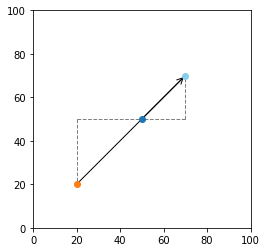

In [2]:
def plot_grid(c1, c1t, c2):

    # make position of fish 1
    x1 = c1[0]
    y1 = c1[1]

    # make next positon of fish 1
    x1t = c1t[0]
    y1t = c1t[1]

    # make positon of fish 2
    x2 = c2[0]
    y2 = c2[1]

    # plot positions
    fig, ax = plt.subplots()

    # markers
    ax.plot(x1, y1, "o", color = "tab:blue")
    ax.plot(x1t, y1t, "o", color = "skyblue")
    ax.plot(x2, y2, "o", color = "tab:orange")

    # connectors
    ax.plot([x1, x1t], [y1, y1t], color = "black", alpha = 1, lw = 1, zorder=-100)
    ax.plot([x1, x2], [y1, y2], color = "black", alpha = 1, lw = 1, zorder=-100)

    # helpers 
    ax.plot([x1-(x1-x2), x1], [y1, y1], color = "black", alpha = 0.5, lw = 1, ls = "dashed", zorder=-100)
    ax.plot([x2, x2], [y1, y1- (y1-y2)], color = "black", alpha = 0.5, lw = 1, ls = "dashed", zorder=-100)
    ax.plot([x1-(x1-x1t), x1], [y1, y1], color = "black", alpha = 0.5, lw = 1, ls = "dashed", zorder=-100)
    ax.plot([x1t, x1t], [y1, y1- (y1-y1t)], color = "black", alpha = 0.5, lw = 1, ls = "dashed", zorder=-100)

    # limits
    ax.set_ylim(0,100)
    ax.set_xlim(0,100)
    ax.set_aspect("equal")

    return ax.lines[3]

def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size, zorder = -100
    )

c1 = [50,50]
c1t = [70, 70]
c2 = [20,20]
traj = plot_grid(c1, c1t, c2)
add_arrow(traj)

In [3]:
# example values for fish trajectory
adj = c1t[0] - c1[0]
opp = c1t[1] - c1[1]
a = atan2(opp, adj)
print(a)
print(degrees(a))

0.7853981633974483
45.0


In [4]:
# example values for angle between fish
adj  = c2[0] - c1[0]
opp = c2[1] - c1[1]
b = atan2(opp, adj)
print(b)
print(degrees(b))

-2.356194490192345
-135.0


In [5]:
# first transform two radians to keep them positive
a = 2*np.pi + a if a < 0 else a
b = 2*np.pi + b if b < 0 else b 

# get the absolute of the relative angle
# (because its easier and for now we dont care about left or right)
r = np.abs(b - a)

print(f"radians of trajectory: {a}")
print(f"degrees of trajectory {degrees(a)}")

print(f"radians to second fish: {b}")
print(f"degrees to second fish {degrees(b)}")

print(f"abs relative angle in radians: {r}")
print(f"abs relative angle in degrees: {degrees(r)}")

radians of trajectory: 0.7853981633974483
degrees of trajectory 45.0
radians to second fish: 3.9269908169872414
degrees to second fish 225.0
abs relative angle in radians: 3.141592653589793
abs relative angle in degrees: 180.0


In [6]:
# create an index for the "aim" of fish 1 towards fish 2

# transform r to degrees
rd = degrees(r)

# norm right side of unit circle to 0
if rd <= 180:
    aim = 1-rd/180
elif rd > 180:
    aim = (rd-180)/180

print(f"aim index: {aim}")

# this works: The index is 0 when the relative angle is 180 i.e. fish 1 swims into the opposite direction of fish 2, and 1 if the angle is 0, i.e. fish 1 swims directly towards fish 2

aim index: 0.0


In [7]:
# now we need to incorporate the aim index with the velocity! If we multiply the velocity of a fish at a given time with the aim index, we can get and idea about who approaches whom and how "vigorously".

# lets make some functions:
from scipy.signal import find_peaks
from plotstyle import PlotStyle
%matplotlib qt

s = PlotStyle()

# get some nice data:
path = "/home/weygoldt/Data/uni/efish/output/2016-04-20-18_49/"
idx = 8

import pandas as pd

events = pd.read_csv(path + "events.csv")
grid = gt.GridTracks(path, finespec=False, verbose=False)
dyad = gt.Dyad(grid, [int(events.id1[idx]), int(events.id2[idx])])

start = gt.utils.find_closest(dyad.times, events.start[idx]-600)
stop = gt.utils.find_closest(dyad.times, events.stop[idx]+600)

start = 0 
stop = len(dyad.times)

def find_interactions(dyad, start, stop, maxd, peakprom, plot=False):
    
    # make arrays for aim index
    c1 = [dyad.xpos_smth_id1[start:stop], dyad.ypos_smth_id1[start:stop]]
    c2 = [dyad.xpos_smth_id2[start:stop], dyad.ypos_smth_id2[start:stop]]
    t = dyad.times[start:stop]

    # extract aim index
    aims1, relangles1 = gt.utils.aim_index(c1, c2)
    aims2, relangles2 = gt.utils.aim_index(c2, c1)

    # extract distance index (0 at max dist, 1 at min dist)
    dist_index = []
    for dpos in dyad.dpos[start:stop]:
        # if dpos < maxd:
        #     dist_index.append(1-dpos/maxd)
        # else:
        #     dist_index.append(0)
        if dpos < maxd:
            dist_index.append(1)
        else:
            dist_index.append(1)

    # extract velocities
    v1 = gt.utils.velocity2d(t, c1[0], c1[1])
    v2 = gt.utils.velocity2d(t, c2[0], c2[1])

    # compute relative velocities
    vr = gt.utils.veloc(dyad.times[start:stop], dyad.dpos[start:stop])

    interact_index1 = v1 * aims1 * dist_index
    interact_index2 = v2 * aims2 * dist_index

    # find peaks, i.e. attacks
    peaks1 = find_peaks(interact_index1, prominence=peakprom)[0]
    peaks2 = find_peaks(interact_index2, prominence=peakprom)[0]

    if plot:
        fig, ax = plt.subplots(6, 1, figsize=(6,12), sharex= True)

        ax[0].set_title("Fundamental frequencies")
        ax[0].plot(dyad.times[start:stop], dyad.fund_id1[start:stop])
        ax[0].plot(dyad.times[start:stop], dyad.fund_id2[start:stop])

        ax[1].set_title("Velocities of both fish")
        ax[1].plot(t, v1)
        ax[1].plot(t, v2)

        ax[2].set_title("Aim index of both fish, should have peaks where attack is")
        ax[2].plot(t, aims1)
        ax[2].plot(t, aims2)

        ax[3].set_title("Distance index")
        ax[3].plot(t, dist_index)


        ax[4].set_title("Attack index, i.e. v * aim_index * dist_index")
        ax[4].plot(t, interact_index1)
        ax[4].plot(t, interact_index2)

        peakbool1 = np.full(len(interact_index1), False, dtype=bool)
        peakbool2 = np.full(len(interact_index2), False, dtype=bool)
        peakbool1[peaks1] = True
        peakbool2[peaks2] = True

        ax[5].set_title("Attack index masked for approach phases only")
        ax[5].plot(t, interact_index1)
        ax[5].plot(t, interact_index2)
        ax[5].plot(t[peakbool1], interact_index1[peakbool1], ".")
        ax[5].plot(t[peakbool2], interact_index2[peakbool2], ".")

    return peaks1, peaks2

peaks1, peaks2 = gt.utils.find_interactions(dyad, start, stop, maxd=400, peakprom=10, plot=True)

ModuleNotFoundError: No module named 'plotstyle'

In [ ]:
fig, ax = plt.subplots()
ax.plot(dyad.xpos_smth_id1[peaks1[0]-30:peaks1[0]+2], dyad.ypos_smth_id1[peaks1[0]-30:peaks1[0]+2])
ax.plot(dyad.xpos_smth_id2[peaks1[0]-30:peaks1[0]+2], dyad.ypos_smth_id2[peaks1[0]-30:peaks1[0]+2])
ax.set_xlim(0,350)
ax.set_ylim(0,350)

(0.0, 350.0)

In [ ]:
#start = gt.utils.find_closest(dyad.times, events.start[idx])
#stop = gt.utils.find_closest(dyad.times, events.stop[idx])

eventra1 = relangles1[start:stop]
eventra2 = relangles2[start:stop]

distribution1 = np.histogram(eventra1,bins=120, range=(0,360))[0]
distribution2 = np.histogram(eventra2,bins=120, range=(0,360))[0]
theta = np.linspace(0,360,120, endpoint=False)

f = plt.figure()
ax = f.add_subplot(polar=True)
ax.set_theta_zero_location('N'); ax.set_theta_direction(-1)
ax.set_ylim(-20,21)
ax.bar(theta, distribution1, edgecolor="black", width = 20/360 , alpha=0.5)
ax.bar(theta, distribution2, edgecolor="black", width = 20/360 , alpha=0.5)

NameError: name 'relangles1' is not defined

In [ ]:
# extract distance index (0 at max dist, 1 at min dist, thresh at 50 cm dist)
mind, maxd = 0, 300
dist_index = []
for dpos in dyad.dpos:
    if dpos < maxd:
        dist_index.append(1-dpos/maxd)
    else:
        dist_index.append(0)


# dist_index = [(1-dpos/maxd) if dpos < maxd else 0 for dpos in dyad.dpos]
plt.plot(dist_index)

In [ ]:
len(dist_index)

119033

In [ ]:
peaks1

array([2063, 2196])

In [ ]:
dyad.times[1]-dyad.times[0]

0.32769999999999966